In [1]:
#Miles' packages
from astropy.table import Table
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import glob
from astropy import units as u

#data processing
import pandas as pd
import numpy as np
import pickle
import math as math
from tqdm import tqdm
import collections
import copy

#visualizations
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.use('Agg')
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go
import seaborn as sns

#models
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

#data manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

#for my sanity
import warnings
warnings.filterwarnings('ignore')

In [2]:
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [3]:
stream_data_base = 'gaia_mock_streams/'
stream_files = glob.glob(stream_data_base + 'stream*.fits.gz')

We now have all the stream files:

In [4]:
print(len(stream_files))
stream_files[:5]

322


['gaia_mock_streams/stream-178.fits.gz',
 'gaia_mock_streams/stream-9528.fits.gz',
 'gaia_mock_streams/stream-9549.fits.gz',
 'gaia_mock_streams/stream-1954.fits.gz',
 'gaia_mock_streams/stream-2408.fits.gz']

In [5]:
# analysis_stream_data_base = 'noise_points/'
# analysis_stream_files = glob.glob(analysis_stream_data_base + 'stream*.csv')
# len(analysis_stream_files)

# analysis_stream_files = [i[13:] for i in analysis_stream_files]
# analysis_stream_files = [i.split("_")[0] for i in analysis_stream_files]

# len_streams = []

# for i in analysis_stream_files:
#     new_string = 'gaia_mock_streams/' + i + '.fits.gz'
#     table = Table.read(new_string, format='fits')
#     stream = table.to_pandas()
#     len_streams.append(len(stream))

In [6]:
# stream_info = np.column_stack((analysis_stream_files, len_streams))
# stream_info = pd.DataFrame(stream_info, columns = ['stream_name', 'stream_length'])
# stream_info.stream_length = stream_info.stream_length.astype(int)

# obtain_model_streams = ['178','9528', '1954', '2408', '4682', '5402', '3526', '9164', '2985']
# obtain_model_streams = ['stream-'+i for i in obtain_model_streams]
# stream_info_obtain_kNN = stream_info[stream_info.stream_name.isin(obtain_model_streams)]
# stream_info_not_obtain_kNN = stream_info[~stream_info.stream_name.isin(obtain_model_streams)]

In [7]:
# #how many have number of stars > 100
# suff_length = stream_info_not_obtain_kNN[stream_info_not_obtain_kNN.stream_length > 100]
# print(len(suff_length))

# group_b_streams, group_c_streams = train_test_split(suff_length, test_size=0.75, random_state = 1)
# print(len(group_b_streams), len(group_c_streams))

# group_b_streams

In [8]:
#group_b_streams.stream_name

In [9]:
#relevant cut for each stream
cuts = pd.read_csv("cuts/cuts3.csv")

In [10]:
len(cuts)

80

#### let us write a function to extract the Gaia noise points based on some inputs

In [5]:
def obtain_noise(min_ra, max_ra, min_dec, max_dec, max_rel_err, n_points):
    
    qry = f" \n\
    select top {n_points} source_id, \n\
    dr2.ra, \n\
    dr2.dec, \n\
    parallax, \n\
    parallax_error, \n\
    pmra, \n\
    pmdec, \n\
    phot_g_mean_mag,\n\
    phot_bp_mean_mag, \n\
    phot_rp_mean_mag, \n\
    bp_rp, \n\
    bp_g, \n\
    g_rp\n\
    from gaiadr2.gaia_source as dr2 \n\
    where dr2.ra > {min_ra} and dr2.ra < {max_ra} and dr2.dec > {min_dec} and dr2.dec < {max_dec} \n\
    and parallax is not null \n\
    and parallax_error is not null \n\
    and abs(dr2.parallax/dr2.parallax_error) < {max_rel_err} \n\
    and pmra is not null \n\
    and pmdec is not null \n\
    and phot_g_mean_mag is not null \n\
    and phot_bp_mean_mag is not null \n\
    and phot_rp_mean_mag is not null \n\
    and bp_rp is not null \n\
    and bp_g is not null \n\
    and g_rp is not null \n\
    order by random_index"

    data_noise = Gaia.launch_job_async(qry).get_results().to_pandas()
    
    return data_noise

#### Let us define our potential models here

In [6]:
#let us define a function to run logistic regression on our data set and evaluate the results
def log_reg_model(X_train, X_test, y_train, y_test):
    #do the logistic regression modeling
    log_reg = LogisticRegression(random_state=0, solver='lbfgs', max_iter=1000, multi_class='warn').fit(X_train, y_train)
    y_pred = log_reg.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

def knn_model(X_train, X_test, y_train, y_test, k):
    #do the KNN modeling
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)
    y_true = np.array(y_test)
    
    #calculate metrics
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    accuracy = metrics.accuracy_score(y_true, y_pred)

    #calculate the AUC
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    
    return precision, recall, accuracy, auc, y_pred, y_true

#### For each mock stream, we wish to obtain a fixed test set that represents the realistic ratio of non-stream stars to stream stars that we expect after applying an isochrone filter.
#### - This ratio was previously determined to be ~400

In [7]:
def obtain_test_set(list_of_stellar_streams, multiple):

    for i in list_of_stellar_streams:
        table = Table.read(i, format='fits')
        stream = table.to_pandas()
        
        idx = cuts.index[cuts.stream_file==str(i)][0]

        ra_min = cuts.loc[idx].ra_min
        ra_max = cuts.loc[idx].ra_max
        dec_min = cuts.loc[idx].dec_min
        dec_max = cuts.loc[idx].dec_max
        
        #restrict stream to relevant portion
        stream = stream.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

        #obtain noise points such that:
        #- the ratio of stream to noise points in the test set is 1:multiple
        #- this is required because KNN introduces bias when the ratios are imbalanced
        n_points = len(stream) * multiple
        #use max_rel_err of 0.5
        max_rel_err =  0.5

        #we now select our noise points that we will incorporate into our training and test set
        noise_points = obtain_noise(ra_min, ra_max, dec_min, dec_max, max_rel_err, n_points)

        #label our data as "not part of the stream"
        noise_points['stream_mask'] = False
        
        #send to csv
        name = i[18:-8]+'_mul_400_total_noise.csv'
        noise_points.to_csv(name)

    return noise_points

In [8]:
group_a = pd.read_csv('stream_stars_split/group_a/group_a_counts_stars_more_than_fifty.csv', index_col = 0)
#testing the completed streams
#completed_streams = ['stream-5711','stream-4106','stream-522','stream-6446','stream-1954']
#group_a = group_a[group_a.stream_name.isin(completed_streams)]
group_a_limits = pickle.load( open( "new_stream_cut_limits.pkl", "rb" ) ).T.reset_index()
#group_a_limits.stream_name = 'gaia_mock_streams/' + group_a_limits.stream_name + '.fits.gz'
#group_a_limits = group_a_limits.rename(columns={"stream_name": "stream_file"})
group_a_limits = group_a_limits.drop(['index'], axis = 1)
group_b_limits = pickle.load( open( "new_stream_cut_limits_group_b.pkl", "rb" ) ).T.reset_index()
group_b_limits = group_b_limits.drop(['index'], axis = 1)
group_c_limits = pickle.load( open( "new_stream_cut_limits_group_c.pkl", "rb" ) ).T.reset_index()
group_c_limits = group_c_limits.drop(['index'], axis = 1)

In [9]:
group_a_limits.head()

,stream_name,ra_min,ra_max,dec_min,dec_max
0,stream-5711,200.978,231.753,44.11,46.2026
1,stream-4106,203.866,249.921,-75.4487,55.9412
2,stream-522,74.784,146.526,-85.8662,-2.30143
3,stream-6446,0.315513,99.5169,-57.0238,-30.9322
4,stream-4468,300.146,333.635,-64.3059,-20.0114


In [10]:
# group_a_limits_stream = group_a_limits[group_a_limits.stream_name == stream_name[item]]
# ra_min = group_a_limits_stream.ra_min.item()
# ra_max = group_a_limits_stream.ra_max.item()
# dec_min = group_a_limits_stream.dec_min.item()
# dec_max = group_a_limits_stream.dec_max.item()
# stream_star_updated = stream_star_one.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))

group_b_list = ['1012','1667','1698','178','3775','532','5406','5489','8137']
group_b_list = ['stream-'+i for i in group_b_list]
group_b_list

group_c_list = ['1101','1519','247','2805','4717','4807','5402','5713','9528']
group_c_list = ['stream-'+i for i in group_c_list]

In [11]:
group_c_limits = group_c_limits[group_c_limits.stream_name != 'stream-6982']
group_b_c_limits = group_b_limits.append(group_c_limits, ignore_index = True, sort = True)

In [12]:
group_a_stars = glob.glob('stream_stars_split/group_a/' + 'stream*.csv')
group_b_stars = glob.glob('stream_stars_split/group_b_intelligent/' + 'stream*.csv')
group_c_stars = glob.glob('stream_stars_split/group_c_intelligent/' + 'stream*.csv')
all_stars = group_a_stars + group_b_stars + group_c_stars

In [13]:
len(group_a_stars),len(group_b_stars), len(group_c_stars), len(all_stars)
group_c_stars

['stream_stars_split/group_c_intelligent/stream-1698_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-4807_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-3775_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-1519_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-1101_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-5402_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-1012_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-247_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-5406_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-4717_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-9528_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-8137_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-1667_intelligent_cut.csv',
 'stream_stars_split/group

In [14]:
group_c_stars_2 = group_c_stars[3:6]+group_c_stars[9:11]
group_c_stars_2

['stream_stars_split/group_c_intelligent/stream-1519_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-1101_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-5402_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-4717_intelligent_cut.csv',
 'stream_stars_split/group_c_intelligent/stream-9528_intelligent_cut.csv']

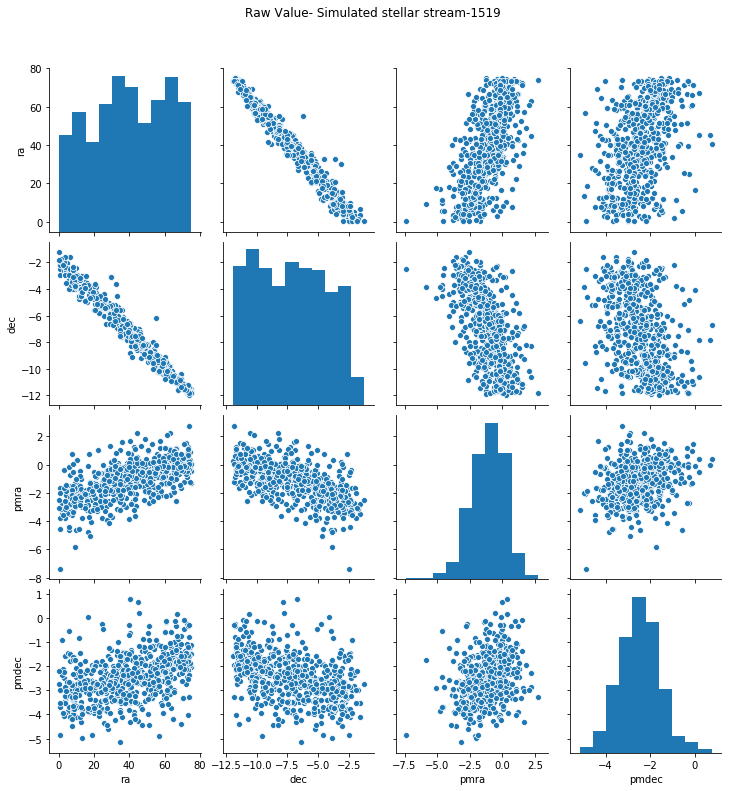

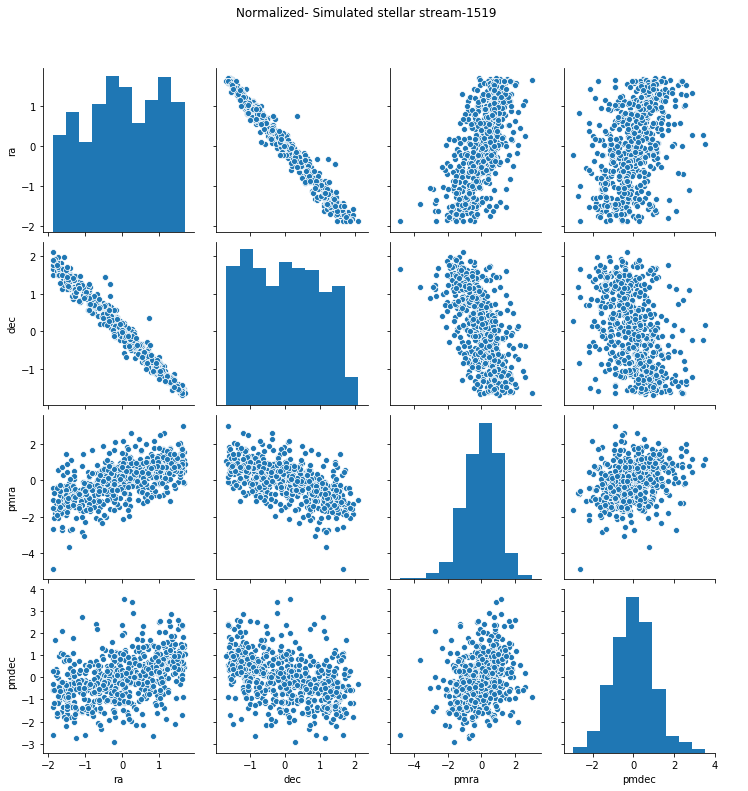

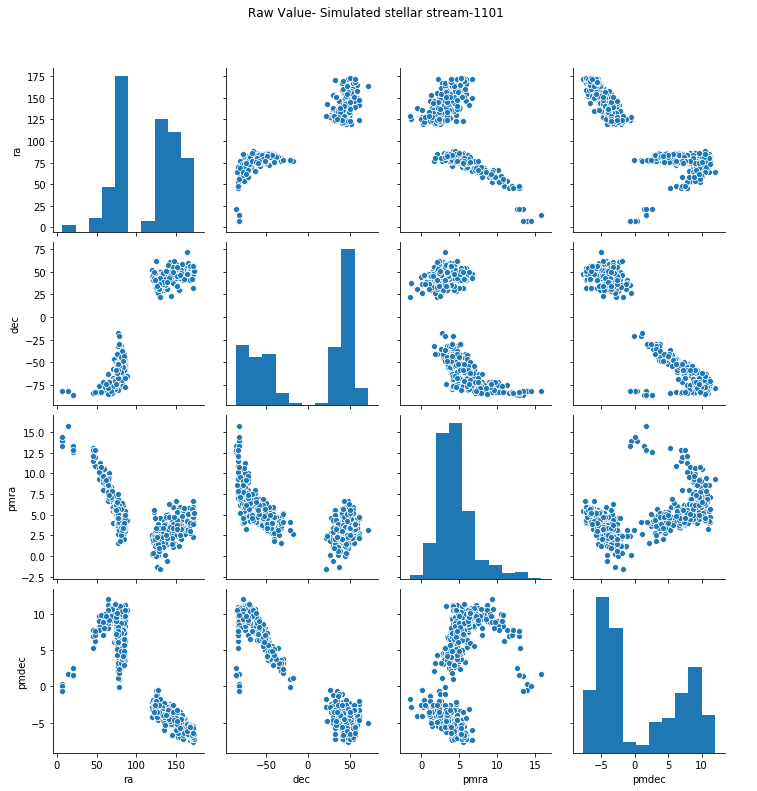

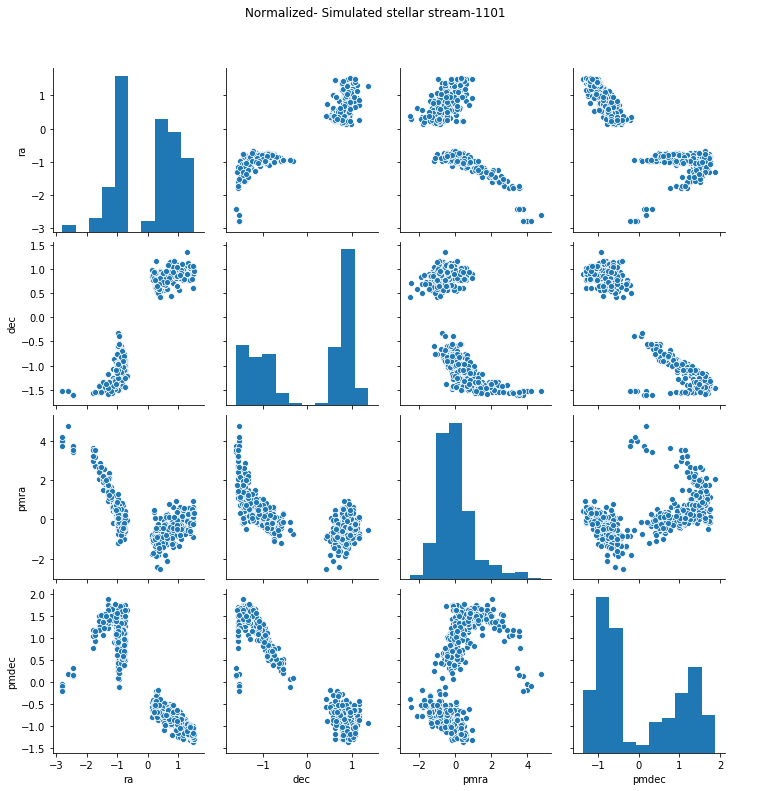

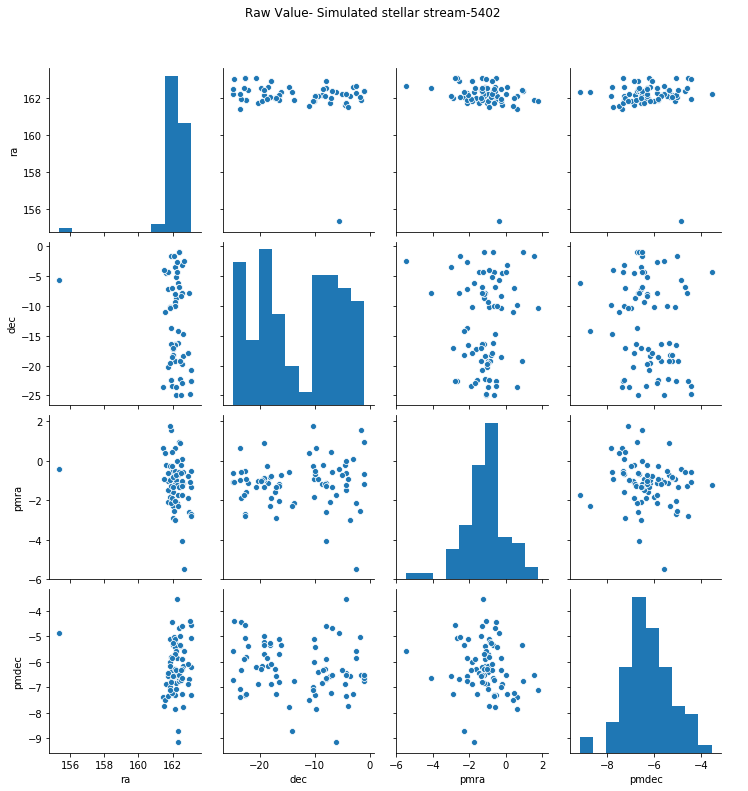

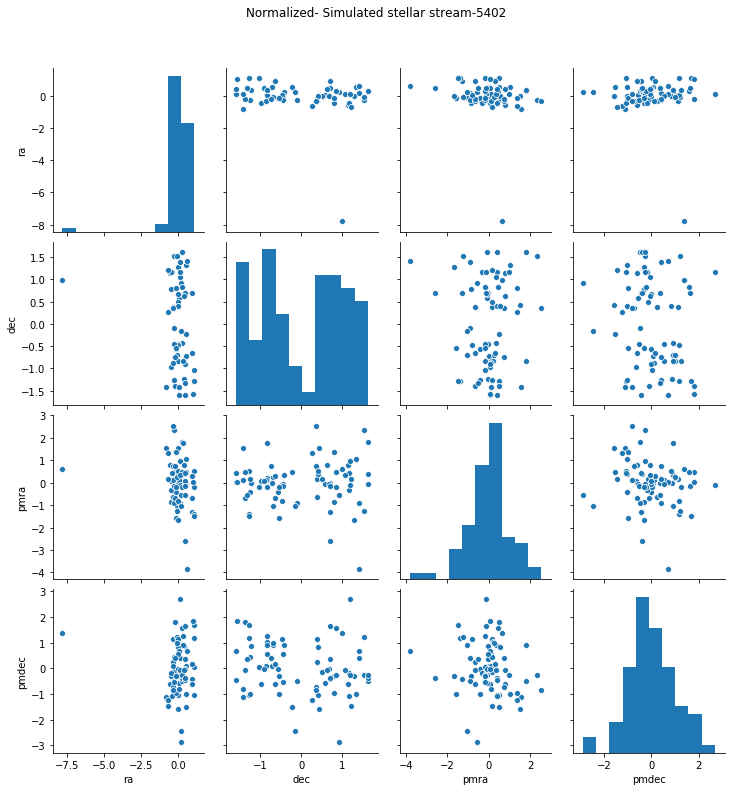

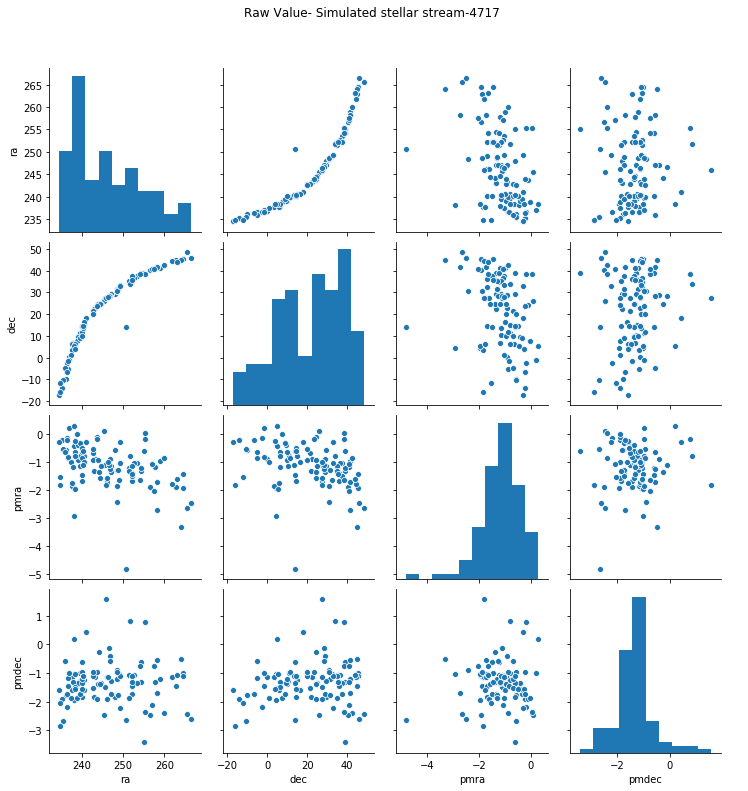

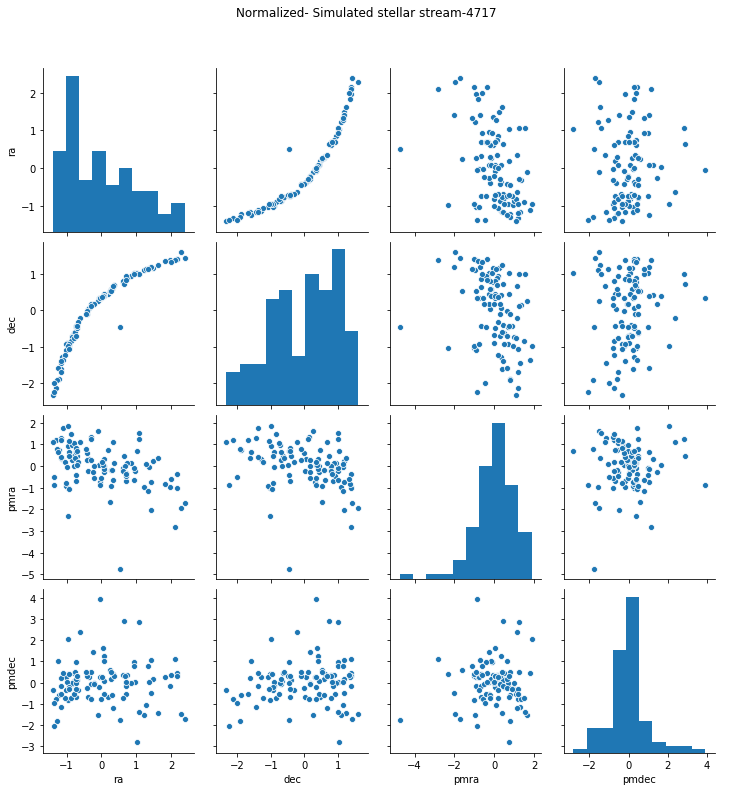

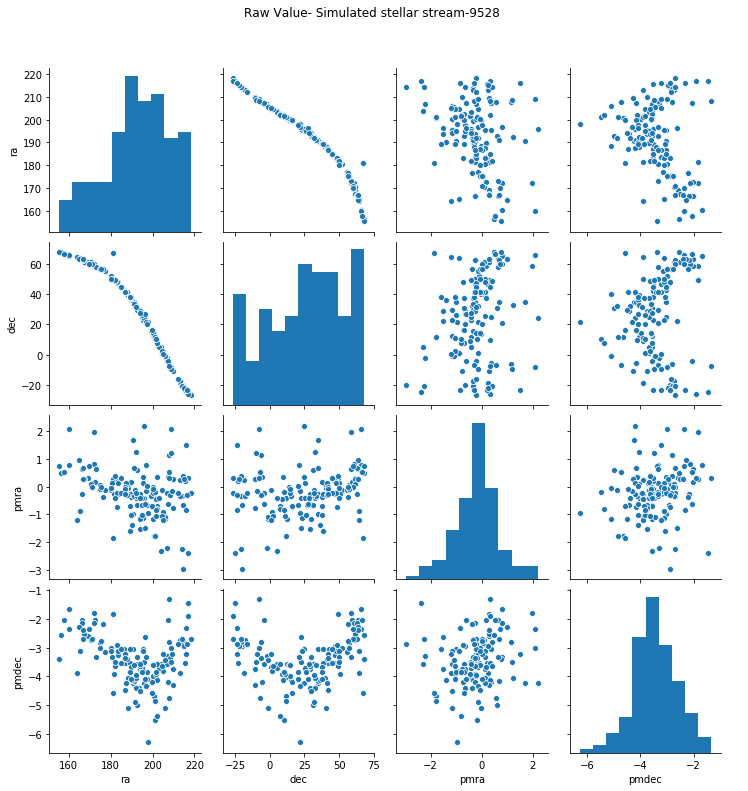

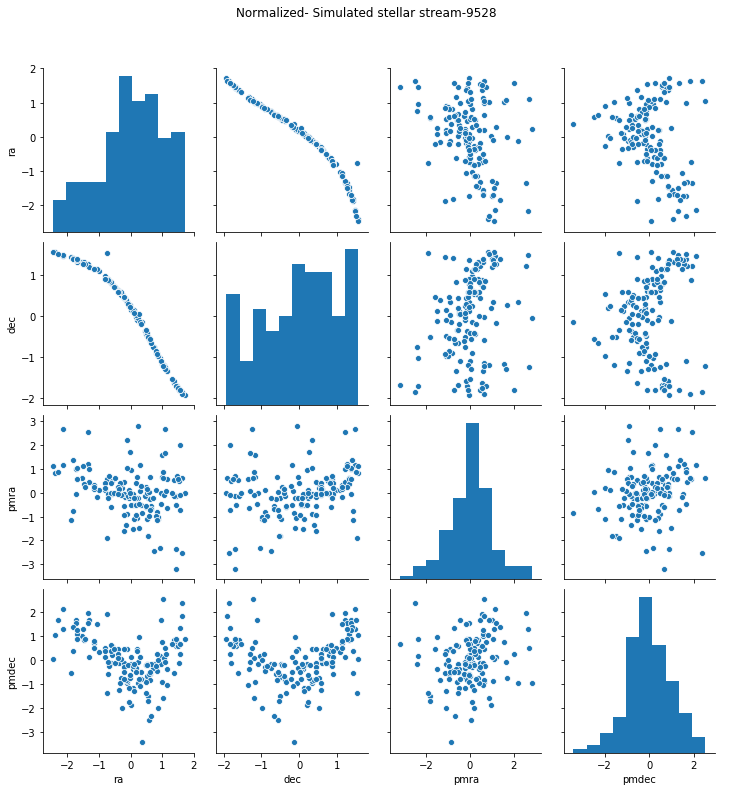

In [23]:
stream_names = [ i.rsplit('/',1)[1][:-20] for i in group_c_stars_2] #all_stars
#stream_name = group_c_list
#stream_stars = ['gaia_mock_streams/' + i + '.fits.gz' for i in stream_name]
#stream_stars = ['stream_stars_split/group_a/' + i + '_intelligent_cut.csv' for i in stream_name]
#stream_background = ['stream_stars_split/simulated_noise_points/150_to_1_ratio/'+i+'_mul_150_total_noise.csv' for i in stream_name]
stream_background = ['stream_stars_split/simulated_noise_points/ratios_intelligent/'+i+'_mul_150_total_noise.csv' for i in stream_names]

for item in range(len(stream_names)): #range(len(stream_name))
    #table = Table.read(stream_stars[item], format='fits')
    #stream_star_one = table.to_pandas()
    stream_star_one = pd.read_csv(group_c_stars_2[item])
    #group_c_limits_stream = group_c_limits[group_c_limits.stream_name == stream_name[item]]
    #ra_min = group_c_limits_stream.ra_min.item()
    #ra_max = group_c_limits_stream.ra_max.item()
    #dec_min = group_c_limits_stream.dec_min.item()
    #dec_max = group_c_limits_stream.dec_max.item()
    stream_star_updated = stream_star_one[abs(stream_star_one.b) > 30]
    stream_star_updated = stream_star_updated[['ra','dec','pmra','pmdec']]
    
    
    #Convert to Angular Coordinates
    #ang_coord_1 = -pmdec * cos(ra) - pmra * cos(dec) * sin(dec) * sin(ra)
    #ang_coord_2 = -pmra * cos(dec) * cos(ra) * sin(dec) + pmdec * sin(ra)
    #ang_coord_3 =  pmra ( cos(dec) * cos(dec) )
    
    deg2rad = lambda deg: deg/180.*np.pi
    
    #Convert data to angular velocities
    #stream_star_updated['ra_rad'] = deg2rad(stream_star_updated['ra'])
    #stream_star_updated['dec_rad'] = deg2rad(stream_star_updated['dec'])
    
    #stream_star_updated['ang_coord_1'] = -1 * stream_star_updated.pmdec * ( np.cos(stream_star_updated.ra_rad)) -  stream_star_updated.pmdec * np.cos(stream_star_updated.dec_rad) * np.sin(stream_star_updated.dec_rad * np.sin(stream_star_updated.ra_rad))
    #stream_star_updated['ang_coord_2'] = -1 * stream_star_updated.pmra *    np.cos(stream_star_updated.dec_rad) * np.cos(stream_star_updated.ra_rad) * np.sin(stream_star_updated.dec_rad + stream_star_updated.pmra * np.sin(stream_star_updated.ra_rad))
    #stream_star_updated['ang_coord_3'] = stream_star_updated.pmra * ( np.cos(stream_star_updated.dec_rad) * np.cos(stream_star_updated.dec_rad) )

    #stream_star_updated = stream_star_one.query('ra > ' + str(ra_min) + ' & ra < ' + str(ra_max) + ' & dec > ' + str(dec_min) + ' & dec < ' + str(dec_max))
    #known, unknown = train_test_split(stream_star_updated, test_size=0.9, random_state = 1)
    #known.to_csv('stream_stars_split/group_c/known_to_model_intelligent/'+ stream_name[item] + '_intelligent_cut.csv')
    #unknown.to_csv('stream_stars_split/group_c/unknown_to_model_intelligent/'+ stream_name[item] + '_intelligent_cut.csv')
    #print(len(stream_star_one), len(stream_star_updated), len(known),len(unknown))
    #stream_background_1 = pd.read_csv(stream_background[item])
    #stream_background_1 = stream_background_1[['ra','dec','pmra','pmdec']]
    #stream_background_1['ra_rad'] = deg2rad(stream_background_1['ra'])
    #stream_background_1['dec_rad'] = deg2rad(stream_background_1['dec'])
    
    #stream_background_1['ang_coord_1'] = -1 * stream_background_1.pmdec * ( np.cos(stream_background_1.ra_rad)) -  stream_background_1.pmdec * np.cos(stream_background_1.dec_rad) * np.sin(stream_background_1.dec_rad * np.sin(stream_background_1.ra_rad))
    #stream_background_1['ang_coord_2'] = -1 * stream_background_1.pmra *    np.cos(stream_background_1.dec_rad) * np.cos(stream_background_1.ra_rad) * np.sin(stream_background_1.dec_rad + stream_background_1.pmra * np.sin(stream_background_1.ra_rad))
    #stream_background_1['ang_coord_3'] = stream_background_1.pmra * ( np.cos(stream_background_1.dec_rad) * np.cos(stream_background_1.dec_rad) )

    
    #known_stars = pd.read_csv('stream_stars_split/group_c/known_to_model/group_c_'+ stream_name[item] + '_known_to_model.csv')
    
    
    #fig = plt.figure(figsize = (20,12))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.scatter(stream_star_updated.ang_coord_1, stream_star_updated.ang_coord_2, stream_star_updated.ang_coord_3, c = 'r', s = 10, alpha = 1, zorder = 5)
    #ax.scatter(stream_background_1.ang_coord_1, stream_background_1.ang_coord_2, stream_background_1.ang_coord_3, c = 'b', s = 0.5, alpha = 0.01, zorder = 0)

    #ax.set_xlabel('ang_coord_1')
    #ax.set_ylabel('ang_coord_2')
    #ax.set_zlabel('ang_coord_3')
    
    #scale the features using standard scaler (scaling not required for logistic regression)
    #scaler = StandardScaler()
    #stream_scaled = scaler.fit(stream_star_updated).transform(stream_star_updated)
    #stream_scaled = pd.DataFrame(stream_scaled, columns = ['ra','dec','pmra','pmdec'])
    
    #background_scaled = scaler.fit(stream_star_updated).transform(stream_background_1)
    #background_scaled = pd.DataFrame(background_scaled, columns = ['ra','dec','pmra','pmdec'])
    if len(stream_star_updated)>2:
        stream_background_1 = pd.read_csv(stream_background[item])
        stream_background_1 = pd.DataFrame(stream_background_1, columns = ['ra','dec','pmra','pmdec'])
        
        scaler = StandardScaler()
        stream_scaled = scaler.fit(stream_star_updated).transform(stream_star_updated)
        stream_scaled = pd.DataFrame(stream_scaled, columns = ['ra','dec','pmra','pmdec'])

        background_scaled = scaler.fit(stream_star_updated).transform(stream_background_1)
        background_scaled = pd.DataFrame(background_scaled, columns = ['ra','dec','pmra','pmdec'])
        
        
        #plt.figure(figsize = (20,12))
        #plt.scatter(known_stars.ra,known_stars.dec, s= 10, alpha = 1, zorder = 10)
        #plt.scatter(stream_star_updated.ra,stream_star_updated.dec, s= 10, alpha = 1, zorder = 5, label = str(len(stream_star_updated)) + ' stream stars')
        #plt.scatter(stream_background_1.ra, stream_background_1.dec, s = 1, alpha = 0.7, zorder = 0, label = str(len(stream_background_1))+ ' background stars')
        #plt.xlabel('ra', fontsize = 30)
        #plt.ylabel('dec', fontsize = 30)
        #plt.title('Simulated stellar ' + stream_names[item], fontsize = 30)
        #plt.legend(fontsize = 20)

        g = sns.pairplot(stream_star_updated)
        g.fig.suptitle('Raw Value- Simulated stellar ' + stream_names[item], y = 1.08)
        
        g = sns.pairplot(stream_scaled)
        g.fig.suptitle('Normalized- Simulated stellar ' + stream_names[item], y = 1.08)
        
#         plt.figure(figsize = (3.5,3))
#         plt.scatter(stream_star_updated.ra,stream_star_updated.dec, s= 10, alpha = 1, zorder = 5)
#         plt.scatter(stream_background_1.ra, stream_background_1.dec, s = 0.1, alpha = 0.7, zorder = 0)
#         plt.xlabel('ra')
#         plt.ylabel('dec')
#         plt.title('Simulated stellar ' + stream_names[item], fontsize = 12)
        
        
        
        
#         plt.figure(figsize = (3.5,3))
#         plt.scatter(stream_scaled.ra,stream_scaled.dec, s= 10, alpha = 1, zorder = 5)
#         plt.scatter(background_scaled.ra, background_scaled.dec, s = 0.1, alpha = 0.7, zorder = 0)
#         plt.xlabel('ra_norm')
#         plt.ylabel('dec_norm')
#         plt.title('Normed Simulated stellar ' + stream_names[item], fontsize = 12)

In [ ]:
stream_name[item]

In [25]:
deg2rad = lambda deg: deg/180.*np.pi
stream_star_updated['ra_rad'] = deg2rad(stream_star_updated['ra'])
stream_star_updated['dec_rad'] = deg2rad(stream_star_updated['dec'])

stream_star_updated['ang_coord_1'] = -1 * stream_star_updated.pmra * ( np.cos(stream_star_updated.ra_rad) + np.cos(stream_star_updated.dec_rad) * np.sin(stream_star_updated.dec_rad * np.sin(stream_star_updated.ra_rad)))
stream_star_updated['ang_coord_2'] = stream_star_updated.pmra * (-1 * np.cos(stream_star_updated.dec_rad) * np.cos(stream_star_updated.ra_rad) * np.sin(stream_star_updated.dec_rad + np.sin(stream_star_updated.ra_rad)))
stream_star_updated['ang_coord_3'] = stream_star_updated.pmra * ( np.cos(stream_star_updated.dec_rad) * np.cos(stream_star_updated.dec_rad) )


In [39]:
stream_background_1

,ra,dec,pmra,pmdec
0,313.820493,-7.060196,0.918697,-1.015494
1,351.500443,7.089660,1.057651,-4.110078
2,309.512353,-29.944991,-3.305349,-10.273282
3,345.904791,13.700465,1.501668,-8.814259
4,358.129956,1.567184,2.141735,-2.060415
...,...,...,...,...
54745,312.559980,-37.157995,-0.830758,-0.628243
54746,309.130044,-34.876797,-2.151921,-5.190439
54747,311.500118,-18.485920,-2.749356,-7.711079
54748,319.670578,-35.038687,-0.391304,-4.403116


## Filter by 'b' > 30

In [115]:
#filter group_a
stream_a_names = list(group_a_limits.stream_name)
stream_stars_a = ['stream_stars_split/group_a/' + i + '_intelligent_cut.csv' for i in stream_a_names]
for item in tqdm(range(len(stream_stars_a))): #range(len(stream_stars))
    table = pd.read_csv(stream_stars_a[item], index_col = 0)
    c = SkyCoord(ra=table['ra']*u.degree, dec=table['dec']*u.degree, frame='icrs')
    b = [i.deg for i in c.galactic.b]
    table['b']=b
    table.to_csv(stream_stars_a[item])

100%|██████████| 35/35 [00:01<00:00, 20.61it/s]


In [185]:
#filter group_b
stream_b_names = list(group_b_limits.stream_name)
stream_b_names = stream_b_names[:3] + stream_b_names[4:]
stream_stars_b_known = ['stream_stars_split/group_b/known_to_model_intelligent/' + i + '_intelligent_cut.csv' for i in stream_b_names]
stream_stars_b_unknown= ['stream_stars_split/group_b/unknown_to_model_intelligent/' + i + '_intelligent_cut.csv' for i in stream_b_names]

for item in tqdm(range(len(stream_stars_b))): #range(len(stream_stars))
    table_known = pd.read_csv(stream_stars_b_known[item], index_col = 0)
    table_unknown = pd.read_csv(stream_stars_b_unknown[item], index_col = 0)
    table = table_known.append(table_unknown)
    c = SkyCoord(ra=table['ra']*u.degree, dec=table['dec']*u.degree, frame='icrs')
    b = [i.deg for i in c.galactic.b]
    table['b']=b
    table['meets_b_req'] = (abs(table['b']) > 30)
    valid_b = table[abs(table.b)>30]
    rand_bool = np.random.choice(a=[True, False], size=(len(table),),p = [0.1,0.9])
    table['known_to_model'] = rand_bool
    table.to_csv('stream_stars_split/group_b_intelligent/'+stream_b_names[item]+ '_intelligent_cut.csv')

100%|██████████| 9/9 [00:00<00:00, 19.45it/s]


In [186]:
#filter group_c
stream_c_names = list(group_c_limits.stream_name)
stream_c_names.insert(4,'stream-5402')
stream_stars_c_known = ['stream_stars_split/group_c/known_to_model_intelligent/' + i + '_intelligent_cut.csv' for i in stream_c_names]
stream_stars_c_unknown= ['stream_stars_split/group_c/unknown_to_model_intelligent/' + i + '_intelligent_cut.csv' for i in stream_c_names]

for item in tqdm(range(len(stream_stars_c))): #range(len(stream_stars))
    table_known = pd.read_csv(stream_stars_c_known[item], index_col = 0)
    table_unknown = pd.read_csv(stream_stars_c_unknown[item], index_col = 0)
    table = table_known.append(table_unknown)
    c = SkyCoord(ra=table['ra']*u.degree, dec=table['dec']*u.degree, frame='icrs')
    b = [i.deg for i in c.galactic.b]
    table['b']=b
    table['meets_b_req'] = (abs(table['b']) > 30)
    valid_b = table[abs(table.b)>30]
    rand_bool = np.random.choice(a=[True, False], size=(len(table),),p = [0.1,0.9])
    table['known_to_model'] = rand_bool
    table.to_csv('stream_stars_split/group_c_intelligent/'+stream_c_names[item]+ '_intelligent_cut.csv')

100%|██████████| 9/9 [00:00<00:00, 18.41it/s]


In [184]:
stream_c_names

['stream-9528',
 'stream-2805',
 'stream-247',
 'stream-4717',
 'stream-5402',
 'stream-5713',
 'stream-1519',
 'stream-4807',
 'stream-1101']